In [1]:
import numpy as np
import os
import util as u
import MRI_layers_MK1 as mri
import matplotlib.pyplot as plt
import pickle


#import contour #class 

import argparse
#we'll use the above for commandline arguments (scanfiles, maskfile)

#import contour class
from contour import *

<ipython-input-97-52e0aeec79f0>:15: UserWarning: No contour levels were found within the data range.
  plt.contour(masks[0], [0], colors='red')


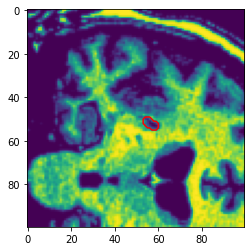

In [97]:
#load data using functions in mri layers module (rename that to mri)
base = "/Users/nathanielnethercott/Desktop/School/2021/Pickled_Sample/"
fpaths = [os.path.join(base,p) for p in os.listdir(base)]

s, m = mri.load_data(fpaths[8])

#contrasting works better when you first isolate the part of the image you want 
#add this in the preprocessing pipeline 
_scans = [scan[50:150, 80:180] for scan in s]
_masks = [mask[50:150, 80:180] for mask in m]

scans, masks = mri.preprocess(_scans, _masks, normalize=True, contrast_factor = 8, blur_rad=0.5)

plt.imshow(scans[0])
plt.contour(masks[0], [0], colors='red')

#index 0: 85:165, 130:210
#index 1: 120:190, 130:210
#index 3: 100:190, 90:190
#index 8: 50:150, 80:180

In [71]:
len(scans)

19

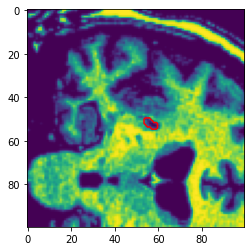

In [72]:
ref = masks[0]

#initial convergence using segmentation
def f0(surface, image):
    F1 = u.mean_curvature(surface)
    F2 = (image-1.0)**2 - (image - 0)**2
    return 0.001*F1 + 0.11*F2

#random circle shape 
p0 = u.parabloid(ref.shape, xrad=0.5, yrad=0.5)
c0 = contour(p0, f0)
c0.iterate(ref, numiters=5500, dt = 0.001)

#check to see that it worked
plt.contour(c0.s, [0], colors='red')
#plt.contour(ref, [0], colors='magenta')
plt.imshow(scans[0])

In [92]:
#now setup some things for the sequential component...

#keep track of contours 
contours = []
contours.append(c0)

#intensities (these are not inherent to dataset, function of preprocess contrast)
interior_intensities = []
exterior_intensities = []

#areas 
area = lambda arr: len(contour.positive_indeces(arr, geq=False))
areas = []


In [93]:
numscans = 3

for i in range(numscans):
    prev_c = contours[i]
    prev_scan = scans[i]
    scan = scans[i+1]
    
    #replace later with area regression estimation
    mask = masks[i+1]
    
    #dynamically define a functional to instantiate contour object with 
    def f(surface, image):
        i_in, i_out = prev_c.intensity(prev_scan, steps=4)
        
        #append 
        interior_intensities.append(i_in)
        exterior_intensities.append(i_out)
        
        #average vals 
        i_in_avg = np.mean(interior_intensities)
        i_out_avg = np.mean(exterior_intensities)
        
        #now use the segmentation functional we've been messing around with 
        F1 = u.mean_curvature(surface)
        F2 = (image-i_in_avg)**2 - (image - i_out_avg)**2

        #consider the area term, right now 
        a0 = area(mask)
        F3 = 2*(area(surface) - 1.0*a0)
    
        return 0.0003*F1 + 0.05*F2 + 0.03*F3
    
    #instantiate
    simplified = u.surf2simple(prev_c.s)
    c = contour(simplified, f)
    
    #iterate
    c.iterate(scan, numiters=3000, dt=0.0015)
    
    #append
    contours.append(c)
    

<ipython-input-101-df90d2e75e3e>:6: UserWarning: No contour levels were found within the data range.
  plt.contour(masks[index], [0], colors='magenta')


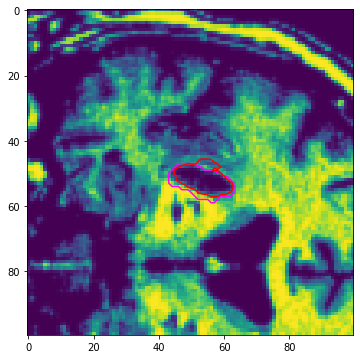

In [101]:
index=3

plt.figure(figsize=(6,6))

plt.imshow(scans[index])
plt.contour(masks[index], [0], colors='magenta')
plt.contour(contours[index].s, [0], colors='red')

In [ ]:
#todo: maybe use os operations to read and write 